## Импорт библиотек

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import demoji
import nltk
import string
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import r2_score, silhouette_score
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-10-12 08:55:16.387716: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 08:55:16.435721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 08:55:17.456263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Считываем данные реакций пользователей Telegram

In [5]:
telegram_df = pd.read_csv('reactions_dataset.csv')

In [6]:
telegram_df = telegram_df.dropna(subset=['post', 'reactions'])

In [7]:
telegram_df = telegram_df.reset_index(drop=True)

### Извлекаем уникальные эмоджи из датасета Telegram

In [8]:
def extract_unique_emojis(reactions):
    emojis = set()
    for reaction in reactions:
        for part in reaction.split(', '):
            emoji = part.split(':')[0]
            emojis.add(emoji)
    return emojis

In [9]:
unique_emojis = extract_unique_emojis(telegram_df['reactions'].tolist())

In [10]:
def clear_emojis(emojis):
    clear_emojis = []
    for emoji in emojis:
        if not '\u200d' in emoji and emoji != 'None' and '\U0001fae1' not in emoji:
            clear_emojis.append(emoji)

    return clear_emojis

In [11]:
unique_emojis = clear_emojis(unique_emojis)

In [12]:
len(unique_emojis)

68

### Просим LLM описать эти смайлики и получаем датасет

In [13]:
emoji_df = pd.read_csv('emoji_description.csv')

In [14]:
emoji_df.head()

,emoji,description
0,🆒,"A blue square with ""cool"" written on it, symbo..."
1,🎄,"A decorated Christmas tree, representing the h..."
2,👌,"A hand making the ""OK"" gesture, signifying app..."
3,🎅,"Santa Claus, a symbol of Christmas, gift-givin..."
4,👾,"An alien monster emoji, often linked to video ..."


### Подгружаем модель трансформер предложений для получения эмбеддингов (векторов) описания эмоджи

In [15]:
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def get_sentence_embeddings(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    with torch.no_grad(): 
        outputs = model(**inputs)
    
    sentences_embeddings = outputs.last_hidden_state[:, 0, :] 
    
    return sentences_embeddings

In [17]:
emoji_texts = emoji_df['description'].tolist()
emojis = emoji_df['emoji'].tolist()

### Получаем эмбеддинги описания эмоджи

In [18]:
emoji_embeddings = get_sentence_embeddings(emoji_texts)

In [19]:
cosine_sim_matrix = cosine_similarity(emoji_embeddings)

### Настраиваем кластеризацию

In [20]:
n_clusters = 3
random_state = 42

### Кластеризируем полученные описательные эмбеддинги эмоджи

In [21]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
kmeans_clusters = kmeans.fit_predict(cosine_sim_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Уменьшаем размерность для визуализации

In [22]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(emoji_embeddings)

### Визуализируем

In [23]:
def visualize(clusters):
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=50)
    plt.title('Clustering of Emoji Embeddings')
    plt.colorbar(label='Cluster')
    plt.show()

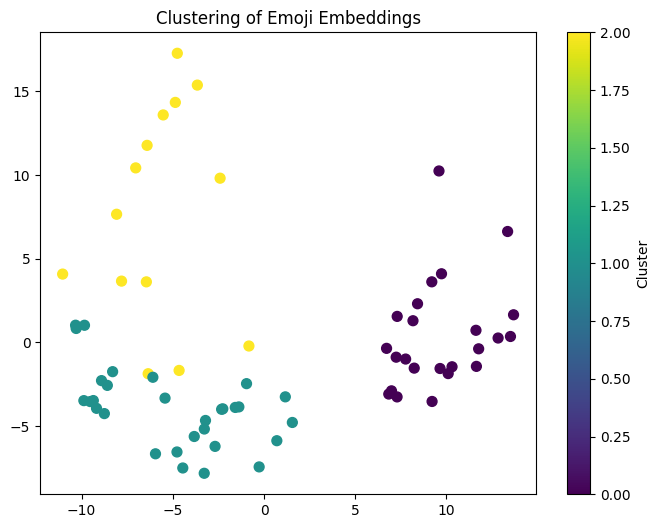

In [24]:
visualize(kmeans_clusters)

### Оценим качество кластеризации эмодзи. В качестве метрики возьмем Коэффициент Силуэта (от -1 до 1, где -1 плохо, а 1 хорошо сгруппированные кластеры)

In [25]:
silhouette_avg = silhouette_score(emoji_embeddings, kmeans_clusters)

In [26]:
silhouette_avg

0.19557595

### Сформируем датафрейм из данных кластеризации и посмотрим, что получилось

In [27]:
emoji_classes_df = pd.DataFrame({
    'emoji': emojis,
    'cluster': kmeans_clusters
})

In [28]:
emoji_classes_df.head(30)

,emoji,cluster
0,🆒,0
1,🎄,0
2,👌,0
3,🎅,0
4,👾,1
5,🍌,1
6,😁,0
7,🍾,0
8,💔,2
9,👏,0


### Исходя из выборочного анализа присвоим следующие лэйблы 0 - позитивные смайлики, 1 - нейтральные, 2 - негативные.

In [29]:
label_map = {
    0: 'POSITIVE',
    1: 'NEUTRAL',
    2: 'NEGATIVE'
}

In [30]:
emoji_classes_df['sentiment'] = emoji_classes_df['cluster'].map(label_map)

In [31]:
emoji_classes_df.head(60)

,emoji,cluster,sentiment
0,🆒,0,POSITIVE
1,🎄,0,POSITIVE
2,👌,0,POSITIVE
3,🎅,0,POSITIVE
4,👾,1,NEUTRAL
5,🍌,1,NEUTRAL
6,😁,0,POSITIVE
7,🍾,0,POSITIVE
8,💔,2,NEGATIVE
9,👏,0,POSITIVE


In [32]:
emoji_classes_df.tail(10)

,emoji,cluster,sentiment
58,🍓,1,NEUTRAL
59,🤔,1,NEUTRAL
60,👎,2,NEGATIVE
61,👍,0,POSITIVE
62,🏆,0,POSITIVE
63,🦄,1,NEUTRAL
64,🥴,2,NEGATIVE
65,✍,1,NEUTRAL
66,🥱,1,NEUTRAL
67,🤪,0,POSITIVE


In [34]:
emoji_classes_df.to_csv('emoji_clustering.csv')

### Из этого датафрейма сформируем словарь для дальнейшего использования

In [33]:
emoji_classes_dict = emoji_classes_df[['emoji', 'sentiment']].set_index('emoji').T.to_dict('records')[0]

In [35]:
telegram_df.head()

,channel_name,channel_link,post,post_link,reactions
0,КБ,https://t.me/Cbpub,К вам в палатку зашла кошка? Теперь это ваша к...,https://t.me/Cbpub/54887,"❤: 314, 😱: 20, 😁: 14, None: 13, 👍: 3, 🎉: 1, 🤮:..."
1,КБ,https://t.me/Cbpub,Невероятная техника рисования от Ричарда Бернера,https://t.me/Cbpub/54886,"👍: 1235, 😱: 290, ❤: 125, 😁: 14, 🗿: 11, 👎: 2, 🤡: 2"
2,КБ,https://t.me/Cbpub,На оф канале Not Pixel Channel выложили пост с...,https://t.me/Cbpub/54885,"👍: 1685, 🎉: 309, 😁: 154, 🤡: 68, ❤: 16, None: 1..."
3,КБ,https://t.me/Cbpub,На порках накатали рисунок 🤣 В игре всего пару...,https://t.me/Cbpub/54884,"👍: 984, ❤: 158, 🤡: 90, 😁: 58, 🤮: 14, 👎: 11, No..."
4,КБ,https://t.me/Cbpub,Не ну ты вообще снимать умеешь? Давай ещё раз!,https://t.me/Cbpub/54883,"❤: 2372, 😁: 695, 👍: 97, 🤡: 12, 🤮: 6, 🗿: 6, 🙏: ..."


### Теперь необходимо вычислить веса для каждого смайлика. Будем использовать частоту реакций

In [36]:
reactions = telegram_df['reactions']

In [37]:
reactions.head()

0    ❤: 314, 😱: 20, 😁: 14, None: 13, 👍: 3, 🎉: 1, 🤮:...
1    👍: 1235, 😱: 290, ❤: 125, 😁: 14, 🗿: 11, 👎: 2, 🤡: 2
2    👍: 1685, 🎉: 309, 😁: 154, 🤡: 68, ❤: 16, None: 1...
3    👍: 984, ❤: 158, 🤡: 90, 😁: 58, 🤮: 14, 👎: 11, No...
4    ❤: 2372, 😁: 695, 👍: 97, 🤡: 12, 🤮: 6, 🗿: 6, 🙏: ...
Name: reactions, dtype: object

In [38]:
def parse_reactions(reaction_str):
    reactions_dict = {}
    items = reaction_str.split(', ')
    for item in items:
        emoji, count = item.split(': ')
        reactions_dict[emoji] = int(count)
    return reactions_dict

In [39]:
parsed_reactions = reactions.apply(parse_reactions)

### Подсчитываем количество каждого смайлика

In [40]:
emoji_counter = Counter()
for reaction in parsed_reactions:
    emoji_counter.update(reaction)

### Получаем общую сумму использований всех смайликов

In [41]:
total_reactions = sum(emoji_counter.values())

### Нормализуем частоты смайликов

In [42]:
emoji_frequencies = {emoji: count / total_reactions for emoji, count in emoji_counter.items()}

In [43]:
emoji_frequencies_df = pd.DataFrame(list(emoji_frequencies.items()), columns=['emoji', 'frequency'])

In [44]:
emoji_frequencies_df.head()

,emoji,frequency
0,❤,0.087197
1,😱,0.057628
2,😁,0.092418
3,None,0.000762
4,👍,0.254689


In [45]:
merged_df = pd.merge(emoji_frequencies_df, emoji_classes_df, on='emoji')

### Вычисляем ранги для каждого класса отдельно

In [46]:
merged_df['rank'] = merged_df.groupby('sentiment')['frequency'].rank(ascending=False, method='min').astype(int)

In [47]:
merged_df = merged_df.sort_values(by=['sentiment', 'rank']).reset_index(drop=True)

In [48]:
merged_df

,emoji,frequency,cluster,sentiment,rank
0,🤬,0.138716,2,NEGATIVE,1
1,😱,0.057628,2,NEGATIVE,2
2,😢,0.044456,2,NEGATIVE,3
3,🙏,0.032609,2,NEGATIVE,4
4,👎,0.025176,2,NEGATIVE,5
...,...,...,...,...,...
63,🤗,0.000011,0,POSITIVE,20
64,🎅,0.000010,0,POSITIVE,21
65,💘,0.000009,0,POSITIVE,22
66,😘,0.000006,0,POSITIVE,23


### Т.к. значения весов слишком большие, то все реакции будут стремиться к нейтральным, поэтому необходимо нормализовать веса

In [49]:
def normalize_rank(rank, step=0.05):
    return round(1 - (rank - 1) * step, 3)

In [50]:
merged_df['normalized_rank'] = merged_df.groupby('sentiment')['rank'].transform(lambda r: normalize_rank(r, step=0.025))

In [51]:
merged_df = merged_df.sort_values(by=['sentiment', 'rank']).reset_index(drop=True)

In [52]:
merged_df

,emoji,frequency,cluster,sentiment,rank,normalized_rank
0,🤬,0.138716,2,NEGATIVE,1,1.000
1,😱,0.057628,2,NEGATIVE,2,0.975
2,😢,0.044456,2,NEGATIVE,3,0.950
3,🙏,0.032609,2,NEGATIVE,4,0.925
4,👎,0.025176,2,NEGATIVE,5,0.900
...,...,...,...,...,...,...
63,🤗,0.000011,0,POSITIVE,20,0.525
64,🎅,0.000010,0,POSITIVE,21,0.500
65,💘,0.000009,0,POSITIVE,22,0.475
66,😘,0.000006,0,POSITIVE,23,0.450


In [53]:
merged_df[merged_df['sentiment']=='NEGATIVE']

,emoji,frequency,cluster,sentiment,rank,normalized_rank
0,🤬,0.138716,2,NEGATIVE,1,1.000
1,😱,0.057628,2,NEGATIVE,2,0.975
2,😢,0.044456,2,NEGATIVE,3,0.950
3,🙏,0.032609,2,NEGATIVE,4,0.925
4,👎,0.025176,2,NEGATIVE,5,0.900
5,🤯,0.009926,2,NEGATIVE,6,0.875
6,🤮,0.006719,2,NEGATIVE,7,0.850
7,😭,0.005674,2,NEGATIVE,8,0.825
8,😡,0.003816,2,NEGATIVE,9,0.800
9,🖕,0.001468,2,NEGATIVE,10,0.775


In [54]:
emoji_ranks_dict = merged_df[['emoji', 'normalized_rank']].set_index('emoji').T.to_dict('records')[0]

### Оставляем только нужные колонки

In [55]:
train_df = telegram_df[['post', 'reactions']]

### Очищаем текстовые данные от всякого мусора

In [56]:
stop_words = set(nltk.corpus.stopwords.words('russian'))

In [57]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]
    
    return words

In [58]:
train_df['text'] = train_df['post'].apply(
    lambda x: demoji.replace(x, "")
)

/tmp/ipykernel_3202/1779771069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['post'].apply(


In [59]:
train_df['text'] = train_df['text'].apply(
    lambda x: clean_text(x)
)

/tmp/ipykernel_3202/4076591217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(


In [60]:
train_df['text'] = train_df['text'].apply(
    lambda x: ' '.join(x)
)

/tmp/ipykernel_3202/1830638885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(


### Не забываем про шумные слова!

In [61]:
def delete_noisy_words(text):
    words_to_delete = ['подписаться', 'прислать', 'shot', 'rgrunews',
                      'моргенштерн', 'ntvnews', 'uraru', 'telegram',
                      'подписывайтесь', 'подписывайся', 'ленту', 'впш']

    for word in words_to_delete:
        text = text.replace(word, ' ')
    
    return ' '.join(text.split())

In [62]:
train_df['text'] = train_df['text'].apply(
    lambda x: delete_noisy_words(x)
)

/tmp/ipykernel_3202/3737310535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(


In [63]:
train_df.head()

,post,reactions,text
0,К вам в палатку зашла кошка? Теперь это ваша к...,"❤: 314, 😱: 20, 😁: 14, None: 13, 👍: 3, 🎉: 1, 🤮:...",палатку зашла кошка это ваша кошка живите этим
1,Невероятная техника рисования от Ричарда Бернера,"👍: 1235, 😱: 290, ❤: 125, 😁: 14, 🗿: 11, 👎: 2, 🤡: 2",невероятная техника рисования ричарда бернера
2,На оф канале Not Pixel Channel выложили пост с...,"👍: 1685, 🎉: 309, 😁: 154, 🤡: 68, ❤: 16, None: 1...",оф канале not pixel channel выложили пост видо...
3,На порках накатали рисунок 🤣 В игре всего пару...,"👍: 984, ❤: 158, 🤡: 90, 😁: 58, 🤮: 14, 👎: 11, No...",порках накатали рисунок игре пару флагов уцеле...
4,Не ну ты вообще снимать умеешь? Давай ещё раз!,"❤: 2372, 😁: 695, 👍: 97, 🤡: 12, 🤮: 6, 🗿: 6, 🙏: ...",вообще снимать умеешь давай ещё


### Получаем лэйблы

In [64]:
def get_label(reactions):
    reactions_split = reactions.split(',')

    positive_quantity = 0
    negative_quantity = 0
    quantity = 0
    
    for reaction in reactions_split:
        data = reaction.split(':')
        emoji = data[0].strip()
        emoji_quantity = int(data[1].strip())

        quantity += emoji_quantity

        try:
            if emoji_classes_dict[emoji] == 'POSITIVE':
                positive_quantity += emoji_quantity * emoji_ranks_dict[emoji]
            elif emoji_classes_dict[emoji] == 'NEGATIVE':
                negative_quantity += emoji_quantity * emoji_ranks_dict[emoji]
        except:
            pass

    result = round((positive_quantity - negative_quantity) / quantity, 2)
        
    return result

In [65]:
train_df['label'] = train_df['reactions'].apply(
    lambda x: get_label(x)
)

/tmp/ipykernel_3202/3591290988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df['reactions'].apply(


In [66]:
train_df.head()

,post,reactions,text,label
0,К вам в палатку зашла кошка? Теперь это ваша к...,"❤: 314, 😱: 20, 😁: 14, None: 13, 👍: 3, 🎉: 1, 🤮:...",палатку зашла кошка это ваша кошка живите этим,0.80
1,Невероятная техника рисования от Ричарда Бернера,"👍: 1235, 😱: 290, ❤: 125, 😁: 14, 🗿: 11, 👎: 2, 🤡: 2",невероятная техника рисования ричарда бернера,0.64
2,На оф канале Not Pixel Channel выложили пост с...,"👍: 1685, 🎉: 309, 😁: 154, 🤡: 68, ❤: 16, None: 1...",оф канале not pixel channel выложили пост видо...,0.92
3,На порках накатали рисунок 🤣 В игре всего пару...,"👍: 984, ❤: 158, 🤡: 90, 😁: 58, 🤮: 14, 👎: 11, No...",порках накатали рисунок игре пару флагов уцеле...,0.86
4,Не ну ты вообще снимать умеешь? Давай ещё раз!,"❤: 2372, 😁: 695, 👍: 97, 🤡: 12, 🤮: 6, 🗿: 6, 🙏: ...",вообще снимать умеешь давай ещё,0.95


In [67]:
train_df['label'].max()

1.0

In [68]:
train_df['label'].min()

-1.0

### Сформирум классы настроений на основе label

In [69]:
def get_sentiment_class(label):
    if label >= -1 and label < -0.33:
        return 'NEGATIVE'
    elif label >= -0.33 and label < 0.33:
        return 'NEUTRAL'
    elif label > 0.33 and label <= 1:
        return 'POSITIVE'

In [70]:
train_df['sentiment_class'] = train_df['label'].apply(
    lambda x: get_sentiment_class(x)
)

In [71]:
train_df.head()

,post,reactions,text,label,sentiment_class
0,К вам в палатку зашла кошка? Теперь это ваша к...,"❤: 314, 😱: 20, 😁: 14, None: 13, 👍: 3, 🎉: 1, 🤮:...",палатку зашла кошка это ваша кошка живите этим,0.80,POSITIVE
1,Невероятная техника рисования от Ричарда Бернера,"👍: 1235, 😱: 290, ❤: 125, 😁: 14, 🗿: 11, 👎: 2, 🤡: 2",невероятная техника рисования ричарда бернера,0.64,POSITIVE
2,На оф канале Not Pixel Channel выложили пост с...,"👍: 1685, 🎉: 309, 😁: 154, 🤡: 68, ❤: 16, None: 1...",оф канале not pixel channel выложили пост видо...,0.92,POSITIVE
3,На порках накатали рисунок 🤣 В игре всего пару...,"👍: 984, ❤: 158, 🤡: 90, 😁: 58, 🤮: 14, 👎: 11, No...",порках накатали рисунок игре пару флагов уцеле...,0.86,POSITIVE
4,Не ну ты вообще снимать умеешь? Давай ещё раз!,"❤: 2372, 😁: 695, 👍: 97, 🤡: 12, 🤮: 6, 🗿: 6, 🙏: ...",вообще снимать умеешь давай ещё,0.95,POSITIVE


In [72]:
value_counts = train_df['sentiment_class'].value_counts()

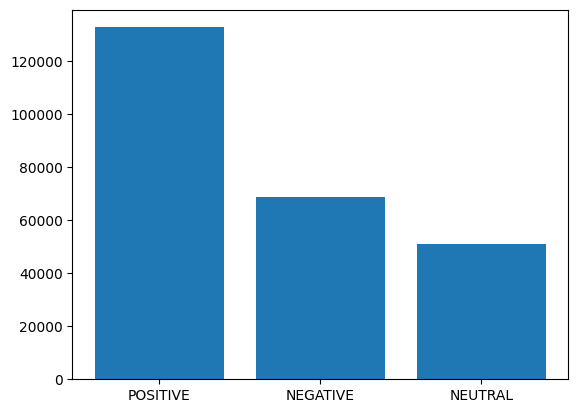

In [73]:
plt.bar(value_counts.index, value_counts.values)
plt.show()

### Осталось обучить и вопрос, что лучше классификация или регрессия? Есть лэйблы для того и другого. Начнем с регрессии и посмотрим на потери и метрики

In [74]:
train_df = train_df[['text', 'label']]

In [75]:
train_df = train_df.dropna(subset=['text'])

In [76]:
train_df['text'] = train_df['text'].astype(str)

In [236]:
train_df = train_df.dropna(subset=['text'])

In [77]:
train_df.to_csv('train_dataset.csv', index=False)

In [152]:
train_df = pd.read_csv('train_dataset.csv')

In [183]:
train_df.head()

,text,label
0,палатку зашла кошка это ваша кошка живите этим,0.80
1,невероятная техника рисования ричарда бернера,0.64
2,оф канале not pixel channel выложили пост видо...,0.92
3,порках накатали рисунок игре пару флагов уцеле...,0.86
4,вообще снимать умеешь давай ещё,0.95


In [237]:
train_df = train_df.reset_index(drop=True)

### Формируем torch dataset

In [248]:
class ReactionsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.dataframe = dataframe

        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = self.dataframe['text'][idx]
        label = self.dataframe['label'][idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

### Описываем модель нейронной сети. На самом деле берем уже обученную на русских текстах модель BERT и дообучаем ее на своих данных

In [249]:
class RegressionModel(nn.Module):
    def __init__(self, base_model, hidden_size=768, output_size=1, dropout_prob=0.1):
        super(RegressionModel, self).__init__()
        self.base_model = base_model 
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)  

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        output = outputs.last_hidden_state[:, 0, :]

        output = self.dropout(output)
        output = self.fc(output)
        
        return output

### А вот и базовая модель 

In [166]:
tokenizer = AutoTokenizer.from_pretrained(
    "DeepPavlov/rubert-base-cased"
)

base_model = AutoModel.from_pretrained(
    "DeepPavlov/rubert-base-cased"
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [250]:
reactions_dataset = ReactionsDataset(train_df, tokenizer)

In [251]:
model = RegressionModel(base_model)

### Разбиваем на тренировочные и валидационные данные

In [252]:
train_size = int(0.8 * len(reactions_dataset))
val_size = len(reactions_dataset) - train_size

In [253]:
train_dataset, val_dataset = random_split(reactions_dataset, [train_size, val_size])

In [254]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

### Функция обучения

In [259]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    all_preds = []
    all_targets = []
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_preds.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    r2 = r2_score(all_targets, all_preds)
    
    return avg_loss, r2

### Функция валидации (тестирования)

In [260]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()

            all_preds.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    r2 = r2_score(all_targets, all_preds)  
    
    return avg_loss, r2

In [261]:
epochs = 3
device = 'cpu'
learning_rate = 1e-5

In [262]:
model = model.to(device)

In [263]:
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_val_loss = float('inf')
for epoch in range(epochs):
    train_loss, train_r2 = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_r2 = validate(model, val_loader, criterion, device)

    print(f"Эпоха {epoch+1}/{epochs}:")
    print(f"  Потеря на тренировке: {train_loss:.4f}, R² на тренировке: {train_r2:.4 f}")
    print(f"  Потеря на валидации: {val_loss:.4f}, R² на валидации: {val_r2:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, 'model_regr_v3.pth')
        print(f"Модель сохранена на {epoch+1}-й эпохе с потерей на валидации: {val_loss:.4f}")